# Circuit testing


This module that generates circuits on a graph which represents the QPU or QVM lattice. The basic idea is it will compute error rates of circuits as a function of depth and width.

The `width` of the circuit is the number of connected vertices on a particular subgraph.

The `depth` is defined in an unusual way. We consider a "depth 1" circuit to be a round of X gates randomly applied or not to a particular vertex AND a round of CNOTs randomly applied or not to each edge of the graph.

## Imports

In [1]:
import random
import itertools
import networkx as nx
import numpy as np
import pandas as pd
import time
# from scipy.spatial.distance import hamming
# import scipy.interpolate

from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer, get_benchmarker
from pyquil.gates import CNOT, CCNOT, Z, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma

from forest.benchmarking.circuit_testing import *

## Get lattice

In [2]:
# if you want to run on a "real lattice"
from pyquil import *
#list_quantum_computers()
#qc_perfect = get_qc("Aspen-1-16Q-A", as_qvm=True, noisy=False)
#qc_noisy = get_qc("Aspen-1-16Q-A") #, as_qvm=True, noisy=True)

qc_perfect = get_qc("9q-square-qvm", as_qvm=True, noisy=False)
qc_noisy = get_qc("9q-square-qvm", as_qvm=True, noisy=True)

In [3]:
#qc_perfect.device.get_specs()

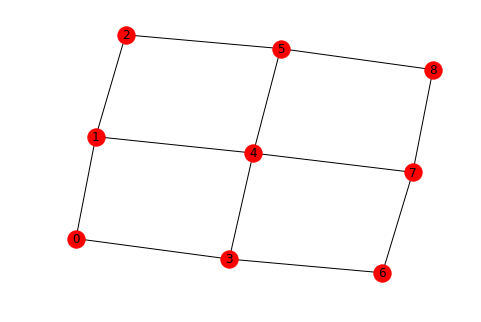

In [4]:
nx.draw(qc_perfect.qubit_topology(),with_labels=True)

In [5]:
G = qc_perfect.qubit_topology()

# gate sets

In [6]:
def two_q_id(qb1,qb2):
    prog = Program()
    prog +=I(qb1)
    prog +=I(qb2)
    return prog

In [7]:
one_q_gates = [X,Z,I]
two_q_gates = [two_q_id,CZ]

one_c_gates = [X,I]
two_c_gates = [two_q_id,CNOT]

In [8]:
prog1 = random_single_qubit_gates(G, one_q_gates)
prog2 = random_two_qubit_gates(G, two_q_gates)
print(prog1+prog2)

Z 0
Z 1
Z 2
I 3
I 4
I 5
X 6
I 7
X 8
CZ 0 3
I 0
I 1
CZ 1 4
CZ 1 2
CZ 2 5
CZ 3 6
CZ 3 4
I 4
I 7
I 4
I 5
CZ 5 8
I 6
I 7
I 7
I 8



# random cliffords

In [9]:
from forest.benchmarking.randomized_benchmarking import get_rb_gateset

In [10]:
# my config has gone all cattywampus so i need to do this
bm = get_benchmarker()#endpoint='tcp://localhost:6000')

In [11]:
bm.client.endpoint

'tcp://127.0.0.1:5555'

In [12]:
gateset_1q, q_placeholders1 = get_rb_gateset(rb_type='1q')
gateset_2q, q_placeholders2 = get_rb_gateset(rb_type='2q')

In [13]:
progy = random_single_qubit_cliffords(G, bm)
print(progy)

RZ(pi/2) 0
RX(-pi) 0
RZ(pi/2) 1
RX(pi/2) 1
RZ(-pi/2) 2
RX(-pi/2) 2
RZ(-pi/2) 3
RX(-pi/2) 3
RX(-pi) 4
RX(-pi/2) 5
RZ(-pi/2) 5
RX(-pi/2) 6
RZ(-pi) 6
RX(pi/2) 7
RZ(-pi/2) 8
RX(-pi) 8



# Make a Template

In [14]:
def oneq_twoq_rand_layer(qc, graph, width, depth, sequence, index):
    prog1 = random_single_qubit_gates(graph, one_q_gates)
    prog2 = random_two_qubit_gates(graph, two_q_gates)
    return prog1 + prog2, index+1

rand_gate_sandwich_circuit = CircuitTemplate((oneq_twoq_rand_layer, ))

In [15]:
print(rand_gate_sandwich_circuit.sample(qc_noisy, G, 2, 2)[0])

X 0
X 1
Z 2
I 3
I 4
X 5
Z 6
Z 7
X 8
I 0
I 3
CZ 0 1
I 1
I 4
I 1
I 2
CZ 2 5
CZ 3 6
I 3
I 4
CZ 4 7
I 4
I 5
I 5
I 8
CZ 6 7
CZ 7 8



# Quantum Volume

In [17]:
def quantum_volume_layer(qc, graph, width, depth, sequence, index):
    prog1 = random_permutation(graph, width)
    prog2 = random_su2_pairs(graph, width)
    return prog1 + prog2, index+1

qv_template = CircuitTemplate((quantum_volume_layer, ))

In [18]:
print(qv_template.sample(qc_noisy, G, 2, 2))

[<pyquil.quil.Program object at 0x7fc0707d8b38>, <pyquil.quil.Program object at 0x7fc0707ec2b0>]


In [ ]:

circuit_depth = 3
circuit_width = 3
circuit_sandwich = partial(circuit_sandwich_rand_gates,
                           one_q_gates = one_c_gates, 
                           two_q_gates = two_c_gates)
layer_dagger = False
sandwich_dagger = False
num_rand_subgraphs = 2
num_shots_per_circuit = 2
use_active_reset= False

In [ ]:
exp = generate_sandwich_circuits_experiments(qc_noisy,circuit_depth,circuit_width, circuit_sandwich, layer_dagger, sandwich_dagger, num_rand_subgraphs, num_shots_per_circuit, use_active_reset)

In [ ]:
exp

In [ ]:
dat = acquire_circuit_sandwich_data(qc_noisy,exp)

In [ ]:
dat

In [ ]:
estimate_random_classical_circuit_errors(qc_perfect,daty)

# Plot the distribution of sublattice widths

In [ ]:
G = qc_perfect.qubit_topology()
len(qc_perfect.qubit_topology())
# distribution of graph lengths
disty = []
for gdx in range(1,len(G.nodes)+1):
    listg = generate_connected_subgraphs(G,gdx)
    disty.append(len(listg))

cir_wid = list(range(1,len(G.nodes)+1))
plt.bar(cir_wid, disty, width=0.61, align='center')
plt.xticks(cir_wid)
plt.xlabel('sublattice / circuit width')
plt.ylabel('Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of sublattice widths')
disty

# Acquire data in Z basis

In [ ]:
# # with these parameters the cell below takes about 1 hour 40 minutes
# num_shots_per_circuit = 400
# num_rand_subgraphs = 16
# circuit_depth = 18
# circuit_width = 15 #max = len(G.nodes)
# x_basis = False
# active_reset = True
# total == 6077

In [ ]:
# with these parameters the cell below takes about 5 minutes
num_shots_per_circuit = 1000
num_rand_subgraphs = 20
circuit_depth = 6
circuit_width = 4 #max = len(G.nodes)
x_basis = False
active_reset = False

In [ ]:
exp =generate_rand_cir_for_rand_lattices_experiments(qc_noisy, 
                                                     circuit_depth, 
                                                     circuit_width,
                                                     num_rand_subgraphs, 
                                                     num_shots_per_circuit, 
                                                     in_x_basis=x_basis, 
                                                     use_active_reset=active_reset)
exp

Collect data.

In [ ]:
t0 = time.time()
data_zbasis = acquire_data_random_classical_circuit(qc_perfect, qc_noisy, exp)
t1 = time.time()
total = t1-t0
print(total)

In [ ]:
data_zbasis

Save the dataframe

In [ ]:
#data_zbasis.to_pickle("data_z_Aspen-1-16Q-A_2019_02_16.pkl")

In [ ]:
data_zbasis = pd.read_pickle('data_z_Aspen-1-16Q-A_2019_02_16.pkl')

In [ ]:
# circuit_width = df['Width'].max()
# circuit_depth = df['Depth'].max()
# for depth, subgraph_size in itertools.product(range(1, circuit_depth+1), range(1, circuit_width+1)):
#     print(depth,subgraph_size)

In [ ]:
dfz = pd.DataFrame(data_zbasis)
dfz.to_pickle("data_z_Aspen_1_15Q_A_2019_02_09.pkl")

In [ ]:
df = pd.read_pickle('data_z_Aspen_1_15Q_A_2019_02_09.pkl')

# Acquire data in X basis

In [ ]:
exp_xbasis = exp.copy()
exp_xbasis['In X basis']=True

In [ ]:
t0x = time.time()
data_xbasis = acquire_data_random_classical_circuit(qc_perfect, qc_noisy, exp_xbasis)
t1x = time.time()
totalx = t1x-t0x
print(totalx)

In [ ]:
dfx = pd.DataFrame(data_xbasis)
dfx.to_pickle("data_x_Aspen_1_15Q_A_2019_02_09.pkl")

Now put the data into a dataframe

In [ ]:
#data_xbasis.to_pickle("data_x_Aspen-1-16Q-A_2019_02_16.pkl")

In [ ]:
#data_xbasis = pd.read_pickle('data_x_Aspen-1-16Q-A_2019_02_16.pkl')

# Data processing and estimation

In [ ]:
res_df = estimate_random_classical_circuit_errors(data_zbasis)

In [ ]:
circuit_width = res_df['Width'].max()

for subgraph_size in range(1, circuit_width+1):
    wdx = data_zbasis['Width']==subgraph_size
    res_df[wdx]
    
    df.append(df2, ignore_index=True)

In [ ]:
circuit_width = res_df['Width'].max()
circuit_depth = res_df['Depth'].max()
results = []
for depth, subgraph_size in itertools.product(range(1, circuit_depth+1), range(1, circuit_width+1)):
    wdx = data_zbasis['Width']==subgraph_size
    ddx = data_zbasis['Depth']==depth
    ndf= res_df[wdx&ddx].copy()
    results.append({'Depth': depth,
                    'Width': subgraph_size,
                    'In X basis': ndf['In X basis'].iloc[0],
                    'Active Reset': ndf['Active Reset'].iloc[0],
                    'Trials': ndf['Trials'].iloc[0],
                    'Hamming dist. data': ndf['Hamming dist. data'].mean(),
                    'Hamming dist. rand': ndf['Hamming dist. rand'].mean(),
                    'Hamming dist. ideal': ndf['Hamming dist. ideal'].mean(),
                    'TVD(data, ideal)': ndf['TVD(data, ideal)'].mean(),
                    'TVD(data, rand)': ndf['TVD(data, rand)'].mean(),
                    'Pr. success data': ndf['Pr. success data'].mean(),
                    'Pr. success rand': ndf['Pr. success rand'].mean(),
                    'loge = basement[log_2(Width)-1]': ndf['loge = basement[log_2(Width)-1]'].mean(),
                    'Pr. success loge data': ndf['Pr. success loge data'].mean(),
                    'Pr. success loge rand': ndf['Pr. success loge rand'].mean(),
                    })    
munged = pd.DataFrame(results)

In [ ]:
munged

In [ ]:
res_df[wdx&ddx]['Hamming dist. data'].mean()

In [ ]:
res_df[wdx&ddx]['Hamming dist. rand'].mean()

# Plot a particular depth and width

In [ ]:
dep = 6
wid = 4

distz = get_hamming_dist(res_df, dep, wid)


# combine data from different subgraphs
avg_dist = distz['Hamming dist. data'].mean()

# rand data
rand_dist = distz['Hamming dist. rand'][0]

In [ ]:
x_labels = np.arange(0, len(avg_dist))
plt.bar(x_labels, avg_dist, width=0.61, align='center')
plt.bar(x_labels, rand_dist, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurence')
plt.ylim([0,1])
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.show()

# For a particular width plot all depths

In [ ]:
wid = 4
df_fn_depth = get_hamming_dists_fn_depth(res_df, wid)

In [ ]:
for dep in range(1, df_fn_depth.Depth.max()+1):
    idx = df_fn_depth['Depth']== dep
    avg_dist = df_fn_depth[idx]['Hamming dist. data'].mean() 
    rand_dist = df_fn_depth[idx]['Hamming dist. rand'].mean() 
    x_labels = np.arange(0, len(avg_dist))
    plt.subplot(1,df_fn_depth.Depth.max(),dep)
    plt.bar(x_labels, avg_dist, width=0.61, align='center')
    plt.bar(x_labels, rand_dist, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()

Now we can study the sucess probablity, i.e. the zero hamming weight entry above as a function of depth. We first need to extract the data fron the data frame.

In [ ]:
depth_vec = []
pcheck = []
pcheck_rand = []
pcheck_log_errors = []
pcheck_log_errors_rand = []
tvd_rand = []
tvd_ideal = []

for dep in range(1, df_fn_depth.Depth.max()+1):
    idx = df_fn_depth['Depth']== dep
    depth_vec.append(dep)
    pcheck.append(df_fn_depth[idx]['Pr. success data'].mean()) 
    pcheck_rand.append(df_fn_depth[idx]['Pr. success rand'].mean())
    pcheck_log_errors.append(df_fn_depth[idx]['Pr. success loge data'].mean())
    pcheck_log_errors_rand.append(df_fn_depth[idx]['Pr. success loge rand'].mean())
    tvd_ideal.append(df_fn_depth[idx]['TVD(data, ideal)'].mean())
    tvd_rand.append(df_fn_depth[idx]['TVD(data, rand)'].mean())

# Success probablity and success probablity including a small number of errors

Next we will plot the success probablity of a circuit with a certain width as a function of depth. 

In [ ]:
plt.scatter(depth_vec,pcheck,label='Sucess Probablity')
plt.plot(depth_vec,pcheck_rand,label='random guess')
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.ylabel('Pr(success)')
plt.title('Pr(success) vs Depth for Width = {}'.format(wid))
plt.legend()
plt.show()

**Sucess if we allow for a small number of errors**

Some near term algorithms have robustness to noise. In light of that we might want to consider answers that are only a little wrong successes.

To make this notion formal we allow a logarithmic number of bits to flip from the correct answer and call all such instances "success".

The logarithmic number of bits that we allow to flip is defined by the "basement" ${\mathcal B}$ of 

$\log_2 ({\rm number\ of\ bits}) -1$

where the basement of a number is ${\mathcal B}(number) = 0$ if number$<=0$ and ${\mathcal B}(number) = {\rm floor (number)}$.


Supose we have a circuit of width 4, this means correct string has four bits, e.g. 1010. Then a logarithmic number of flips is $\log_2(4)-1 = 1$.

So any string with hamming weight zero or one counts as a success.

Such error metrics might be important in noisy near term algorithms where getting the exact answer is not vital.

In [ ]:
plt.figure()
plt.scatter(depth_vec,pcheck,label='Sucess Probablity')
plt.plot(depth_vec,pcheck_rand,label='random guess')
plt.scatter(depth_vec,pcheck_log_errors,label='Sucess Probablity + log errors')
plt.plot(depth_vec,pcheck_log_errors_rand,label='random guess + log errors')
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.ylabel('Pr(success+log errors)')
plt.title('Pr(success+log errors) vs Depth for Width = {}'.format(wid))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

## Total variation distance from ideal answer and random distribution

In [ ]:
plt.figure()
plt.scatter(depth_vec,tvd_ideal,label='TVD(data, ideal)')
plt.scatter(depth_vec,tvd_rand,label='TVD(data, rand)')
plt.scatter(depth_vec,1-np.asarray(pcheck),label='1-Sucess Probablity',alpha=0.33,marker='^',s=80)
#plt.plot(depth_vec,pcheck_log_errors_rand,label='random guess + log errors')
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.ylabel('Total variation distance')
plt.title('Width = {}'.format(wid))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# Plot depth = width

In [ ]:
max_idx = min([max(res_df['Depth']),max(res_df['Width'])])

for idx in range(1,max_idx+1):
    distz = get_hamming_dist(res_df, idx, idx)
    # combine data from different subgraphs
    avg_dist = distz['Hamming dist. data'].mean()
    # rand data
    rand_dist = distz['Hamming dist. rand'][0]
    dep = idx
    wid = idx
    x_labels = np.arange(0, len(avg_dist))
    plt.subplot(1,max_idx,idx)
    plt.bar(x_labels, avg_dist, width=0.61, align='center')
    plt.bar(x_labels, rand_dist, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()

# Plot success probablity landscape

This is just the success probablity as a function of depth and width.

In [ ]:
values = np.asarray([munged['Pr. success data'][idx] for idx in munged.index])
values

In [ ]:
values_rand = np.asarray([munged['Pr. success rand'][idx] for idx in munged.index])
values_rand

In [ ]:
x = np.arange(min(res_df['Depth']), max(res_df['Depth'])+1)

y = np.arange(min(res_df['Width']), max(res_df['Width'])+1)

X, Y = np.meshgrid(x, y)

In [ ]:
(x1,x2) = X.shape
Zdata = np.reshape(values,(x2,x1)).T
Zrand = np.reshape(values_rand,(x2,x1)).T

In [ ]:
Zdata

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Zdata, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability')
plt.show()

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Zrand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

In [ ]:
tvd_rand_values = np.asarray([munged['TVD(data, rand)'][idx] for idx in munged.index])
tvd_ideal_values = np.asarray([munged['TVD(data, ideal)'][idx] for idx in munged.index])
Ztvd_rand = np.reshape(tvd_rand_values,(x2,x1)).T
Ztvd_ideal = np.reshape(tvd_ideal_values,(x2,x1)).T

In [ ]:
tvd_ideal_values
tvd_rand_values

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Ztvd_ideal, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Ztvd_rand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

In [ ]:
loge_rand_values = np.asarray([munged['Pr. success loge rand'][idx] for idx in munged.index])
loge_data_values = np.asarray([munged['Pr. success loge data'][idx] for idx in munged.index])
Zlge_rand = np.reshape(loge_rand_values,(x2,x1)).T
Zlge_data = np.reshape(loge_data_values,(x2,x1)).T

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Zlge_data, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

In [ ]:
extent = min(res_df['Depth'])-0.5, max(res_df['Depth'])+0.5, min(res_df['Width'])-0.5, max(res_df['Width'])+0.5
ax = plt.gca()
img = ax.imshow(Zlge_rand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

xticks = np.arange(1,max(res_df['Depth'])+1)
ax.set_xticks(xticks)
ax.set_xticklabels(map(str, xticks))

yticks = np.arange(1,max(res_df['Width'])+1)
ax.set_yticks(yticks)
ax.set_yticklabels(map(str, yticks))

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability of Random Guess')
plt.show()

# Data exploration

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
size = Y.shape
width_1d = Y.reshape((1,np.prod(size)))
depth_1d = X.reshape((1,np.prod(size)))

In [ ]:
data_1d = Zdata.reshape((1,np.prod(size)))
data_1d.shape
width_1d.shape


In [ ]:
dims = np.zeros_like(width_1d)
dims[0,0] = size[0]
dims[0,1] = size[1]

xdata = np.vstack((dims,width_1d, depth_1d))



xdata

## Fitting models

Two parameter model 


$f(W,D,p_W,p_D) =  (1-p_W)^W * (1-p_D)^D $

The fidelity is proporional to $1 - p$

In [ ]:
def two_param(x,pw,pd):
    temp = x[0]
    wid = temp[0]
    dep = temp[1]
    width = x[1].reshape(wid,dep)
    depth = x[2].reshape(wid,dep)
    pcheck = (1-pw)**(width) * (1-pd)**depth
    rpcheck = pcheck.reshape((1,wid*dep))
    return rpcheck.ravel()

One parameter model

$f(W,D,p) =  (1-p)^{W * D} $

In [ ]:
def one_param(x,p):
    temp = x[0]
    wid = temp[0]
    dep = temp[1]
    width = x[1].reshape(wid,dep)
    depth = x[2].reshape(wid,dep)
    pcheck = (1-p)**(width*depth)
    rpcheck = pcheck.reshape((1,wid*dep))
    return rpcheck.ravel()

From my prior work a better model to fit to is

Pcheck$(W,D,p,a,b,c) = \exp[ -(a p^2 + b p + c)* W*D] $


In [ ]:
def two_param_exp(x,p,a,b):
    temp = x[0]
    wid = temp[0]
    dep = temp[1]
    width = x[1].reshape(wid,dep)
    depth = x[2].reshape(wid,dep)
    pcheck = np.exp(-(a*p + b) * width * depth)
    rpcheck = pcheck.reshape((1,wid*dep))
    return rpcheck.ravel()

**Start with one paramter model**

In [ ]:
pguess = 0.1
popt, pcov = curve_fit(one_param, xdata, data_1d.ravel(), p0=pguess, bounds=(0, 1))

In [ ]:
print('The estimated error is p = ', str(np.round(popt[0],4)))
print('The estimated product of the one and two qubit fidelity is F = ', str(1-np.round(popt[0],4)))
#print('The one standard deviation on the estimate is ', str(np.round(np.sqrt(np.diag(pcov)[0]),5)))

In [ ]:
zfit = one_param(xdata,popt)
Z_fit = zfit.reshape(size)

In [ ]:
plt.pcolormesh(X,Y, Z_fit)
plt.xticks(list(range(1,circuit_depth+1)))
plt.yticks(list(range(1,circuit_width+1)))
plt.colorbar()
plt.show()

In [ ]:
plt.pcolormesh(X,Y,Zdata)
plt.xticks(list(range(1,circuit_depth+1)))
plt.yticks(list(range(1,circuit_width+1)))
plt.colorbar()
plt.show()

**Two parameter model**

In [ ]:
pguess2d = [0.0276, 0.01, 0.4]

In [ ]:
popt2d, pcov2d = curve_fit(two_param_exp, xdata, data_1d.ravel(), p0=pguess2d , bounds=(0., 1))

In [ ]:
popt2d

In [ ]:
zfit2d = two_param(xdata,popt2d[0],popt2d[1])
Z_fit2d = zfit2d.reshape(size)

In [ ]:
plt.pcolormesh(X,Y, Z_fit2d)
plt.xticks(list(range(1,circuit_depth+1)))
plt.yticks(list(range(1,circuit_width+1)))
plt.colorbar()
plt.show()

In [ ]:
1-1.02319786e-01